In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import re, csv, folium, io
from IPython.display import display, HTML
from PIL import Image
from datetime import datetime, timedelta
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from textblob import TextBlob
from geopy.geocoders import Photon
from branca.colormap import LinearColormap
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shahv\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Load the Excel files containing city names
zomato_df = pd.read_excel(r"C:\Users\shahv\Downloads\Zomato Cites.xlsx")
swiggy_df = pd.read_excel(r"C:\Users\shahv\Downloads\Swiggy cities.xlsx")

# Create India maps centered at (20.5937, 78.9629) and zoom level 4
zomato_map = folium.Map(location=[20.5937, 78.9629], zoom_start=3.5)
swiggy_map = folium.Map(location=[20.5937, 78.9629], zoom_start=3.5)

# Mark cities on the map
for _, row in zomato_df.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']], radius=1, color='red', fill=True, fill_color='blue').add_to(zomato_map)

for _, row in swiggy_df.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']], radius=1, color='orange', fill=True, fill_color='blue').add_to(swiggy_map)
    
# Convert maps to HTML
map1_html = zomato_map._repr_html_()
map2_html = swiggy_map._repr_html_()

# Arrange maps side by side using HTML formatting
html_content = f"<div style='display:flex;'>{map1_html}{map2_html}</div>"

# Display the HTML content
display(HTML(html_content))

img_data = zomato_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('C:/Users/shahv/Downloads/zomato.png')

img_data = swiggy_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('C:/Users/shahv/Downloads/swiggy.png')

#Hence, the below images show the market penetration of both Swiggy (Orange) and Zomato (Red) across India.

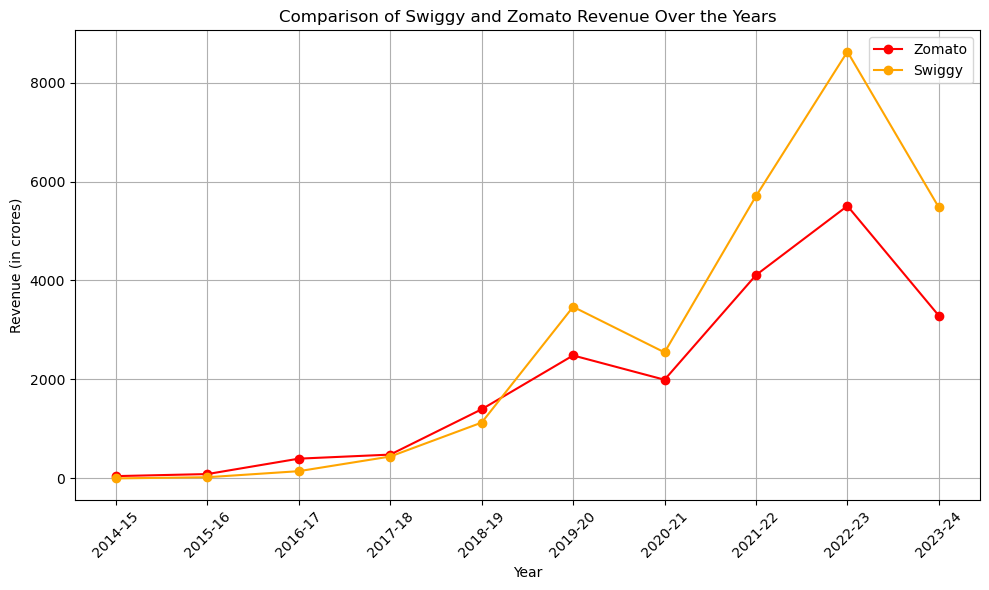

In [3]:
#Revenue Comparison
years = ['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']

#Adding the revenue data (Retrieved from multiple sources) for both companies to list
swiggy_revenue = [0.1159, 23.59, 146, 442, 1128, 3468, 2547, 5705, 8625, 5476]
zomato_revenue = [46, 87.5, 399, 481, 1397, 2485, 1994, 4109, 5506.90, 3288]

#Plotting a line chart
plt.figure(figsize=(10, 6))

plt.plot(years, zomato_revenue, marker='o', label='Zomato', color='red')
plt.plot(years, swiggy_revenue, marker='o', label='Swiggy', color='orange')

plt.xlabel('Year')
plt.ylabel('Revenue (in crores)')
plt.title('Comparison of Swiggy and Zomato Revenue Over the Years')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
#Comparing average delivery times for Swiggy and Zomato

zomato_df = pd.read_csv(r"C:\Users\shahv\Downloads\Zomato Delivery Data.csv")
swiggy_df = pd.read_csv(r"C:\Users\shahv\Downloads\Swiggy Delivery Data.csv")

swiggy_df['PLACED_TIME'] = pd.to_datetime(swiggy_df['PLACED_TIME'])
swiggy_df['DELIVERED_TIME'] = pd.to_datetime(swiggy_df['DELIVERED_TIME'])
swiggy_df['Time_taken'] = (((swiggy_df['DELIVERED_TIME'] - swiggy_df['PLACED_TIME']).dt.total_seconds())/60).round(0)

swiggy_df = swiggy_df[swiggy_df['Time_taken'].notna()]

print("Zomato's average delivery time:", zomato_df['Time_taken (min)'].mean())
print("Swiggy's average delivery time:", swiggy_df['Time_taken'].mean())

Zomato's average delivery time: 26.293962793962795
Swiggy's average delivery time: 41.16955274620206


### Hence, Zomato boasts a way lower average delivery time than Swiggy with a difference of almost 15 minutes!

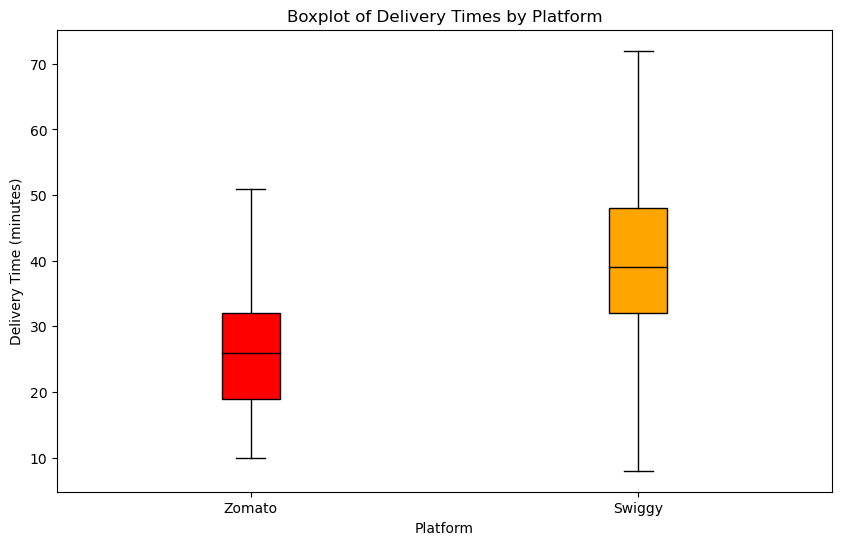

In [5]:
#Visualizing the delivery times of both
plt.figure(figsize=(10, 6))
bp = plt.boxplot([zomato_df['Time_taken (min)'], swiggy_df['Time_taken']], labels=['Zomato', 'Swiggy'], showfliers=False, patch_artist=True)
plt.title('Boxplot of Delivery Times by Platform')
plt.xlabel('Platform')
plt.ylabel('Delivery Time (minutes)')

colors = ['red', 'orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    
for median in bp['medians']:
    median.set_color('black')
    
plt.show()

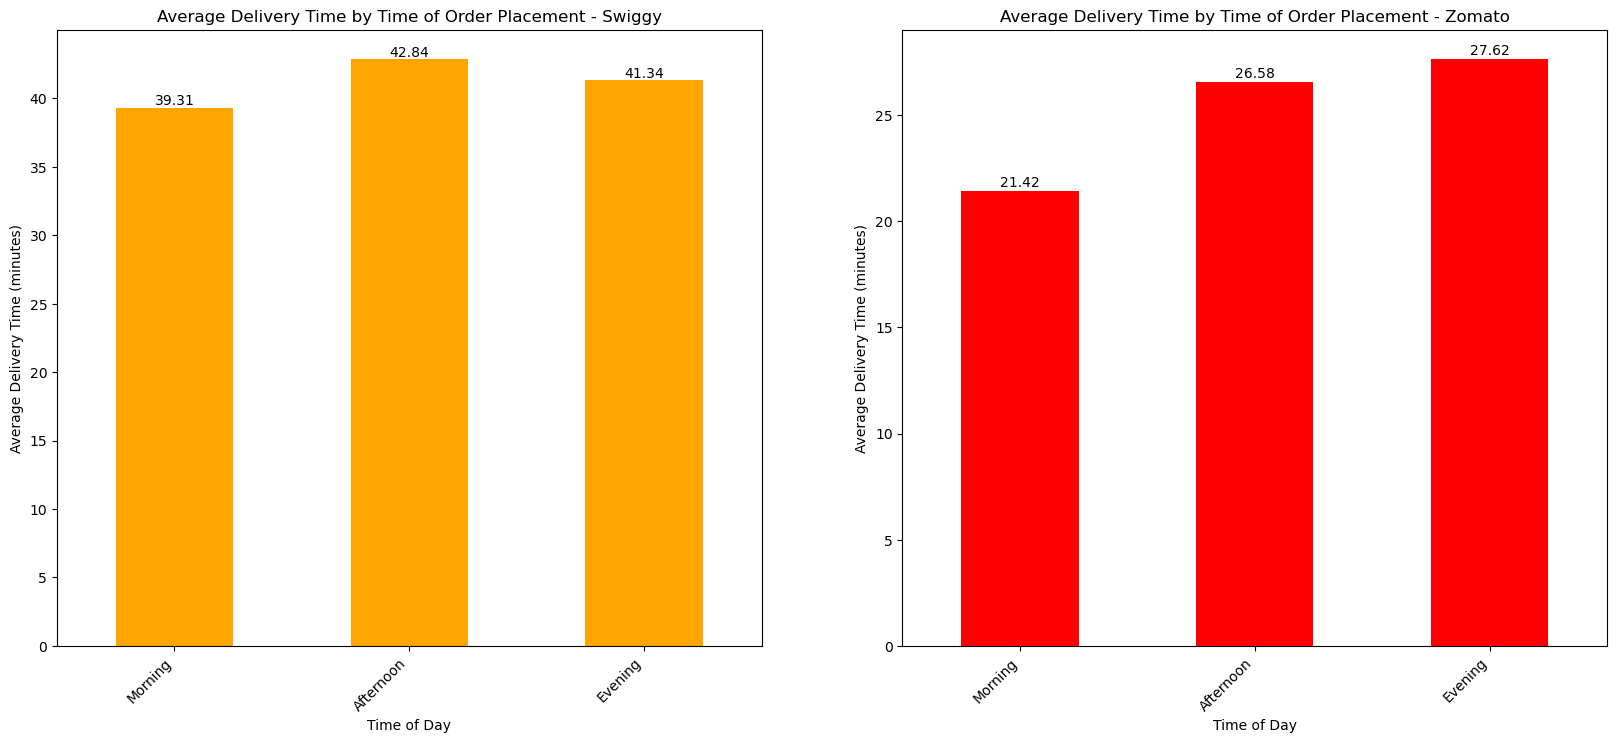

In [6]:
# Extract hour from order_time
swiggy_df['order_hour'] = swiggy_df['PLACED_TIME'].dt.hour

# Categorize orders based on order time
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

swiggy_df['time_of_day'] = swiggy_df['order_hour'].apply(categorize_time)

# Calculate average delivery time for each time category
average_delivery_time = swiggy_df.groupby('time_of_day')['Time_taken'].mean()

#Rearranging zomato_df by time of day
average_delivery_time_swiggy = average_delivery_time.reindex(['Morning','Afternoon','Evening'])

#ZOMATO
zomato_df['PLACED_TIME'] = zomato_df['Order_Date'] + ' ' + zomato_df['Time_Orderd']

#Drop invalid columns
zomato_df = zomato_df[zomato_df['Time_Orderd'].str.contains(":", na=False)]
    
# Convert order_time & delivered_time to datetime
zomato_df['PLACED_TIME'] = pd.to_datetime(zomato_df['PLACED_TIME'])

# Extract hour from order_time
zomato_df['order_hour'] = zomato_df['PLACED_TIME'].dt.hour
zomato_df['time_of_day'] = zomato_df['order_hour'].apply(categorize_time)

#Add delivery mins to order time to get delivery time
zomato_df['DELIVERED_TIME'] = zomato_df['PLACED_TIME'] + pd.to_timedelta(zomato_df['Time_taken (min)'], unit='m')

# Calculate average delivery time for each time category
average_delivery_time = zomato_df.groupby('time_of_day')['Time_taken (min)'].mean()

#Rearranging data by time of day
average_delivery_time_zomato = average_delivery_time.reindex(['Morning','Afternoon','Evening'])

# Visualize results
fig, ax = plt.subplots(1,2, figsize=(20,8))

average_delivery_time_swiggy.plot(kind='bar', xlabel='Time of Day', color='orange', ylabel='Average Delivery Time (minutes)', title='Average Delivery Time by Time of Order Placement - Swiggy', ax=ax[0])
average_delivery_time_zomato.plot(kind='bar', xlabel='Time of Day', color='red', ylabel='Average Delivery Time (minutes)', title='Average Delivery Time by Time of Order Placement - Zomato', ax=ax[1])

# Rotate x-axis tick labels
for axis in ax:
    axis.set_xticklabels(axis.get_xticklabels(), rotation=45, ha='right')

# Add labels to the bars
for i, v in enumerate(average_delivery_time_swiggy):
    ax[0].text(i, v + 0.2, f'{v:.2f}', ha='center')
for i, v in enumerate(average_delivery_time_zomato):
    ax[1].text(i, v + 0.2, f'{v:.2f}', ha='center')

plt.show()

### Hence, afternoons are usually the peak periods for Swiggy while evenings are peak periods for Zomato. They can increase efficiency by assigning more riders during the period where their delivery times faulter the most.

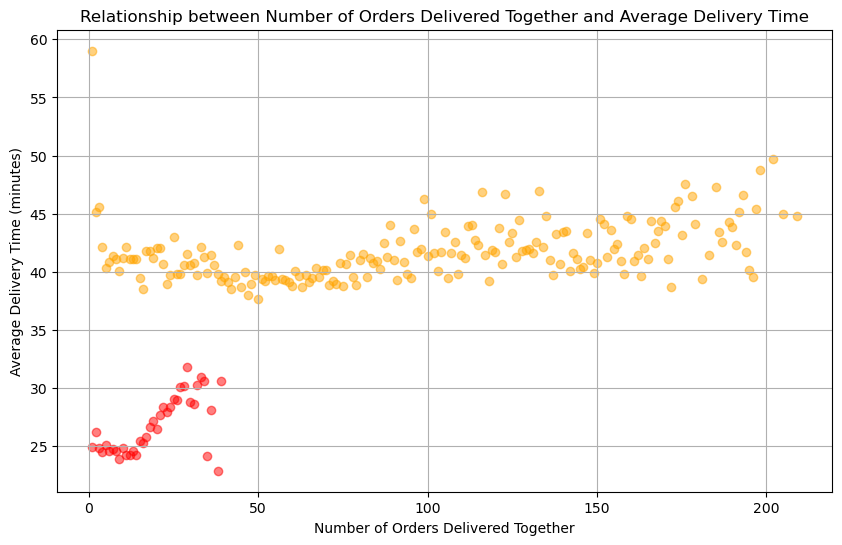

In [7]:
# Sort the DataFrame by PLACED_TIME
swiggy_df = swiggy_df.sort_values(by='DELIVERED_TIME')
zomato_Df = zomato_df.sort_values(by='DELIVERED_TIME')

# Create a new column to represent the 10-minute time window
swiggy_df['Time_Window'] = swiggy_df['DELIVERED_TIME'].dt.floor('10min')
zomato_df['Time_Window'] = zomato_df['DELIVERED_TIME'].dt.floor('10min')

# Group the data by the Time_Window and calculate the delivery time statistics
grp = swiggy_df.groupby(['Time_Window']).count()
grp = grp[['ORDER_ID']]
grp.columns = ['Orders']
grp = pd.merge(grp, swiggy_df, on='Time_Window', how='inner')

delivery_time_stats = grp.groupby('Orders', as_index=False)['Time_taken'].mean()

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(delivery_time_stats['Orders'], delivery_time_stats['Time_taken'], color='orange', alpha=0.5)

# Group the data by the Time_Window and calculate the delivery time statistics
grp = zomato_df.groupby(['Time_Window']).count()
grp = grp[['ID']]
grp.columns = ['Orders']
grp = pd.merge(grp, zomato_df, on='Time_Window', how='inner')

delivery_time_stats = grp.groupby('Orders', as_index=False)['Time_taken (min)'].mean()

plt.scatter(delivery_time_stats['Orders'], delivery_time_stats['Time_taken (min)'], color='red', alpha=0.5)

# Adding labels and title
plt.xlabel('Number of Orders Delivered Together')
plt.ylabel('Average Delivery Time (minutes)')
plt.title('Relationship between Number of Orders Delivered Together and Average Delivery Time')

# Showing the plot
plt.grid(True)
plt.show()

### Hence, from the above plot, we can see that although Zomato's average delivery time is lower than Swiggy at all times and the number of orders handled by Zomato simultaneously is not as high as Swiggy, Zomato's ability to handle bigger number of orders clearly falls with the increase in orders while Swiggy's is more or less consistent.

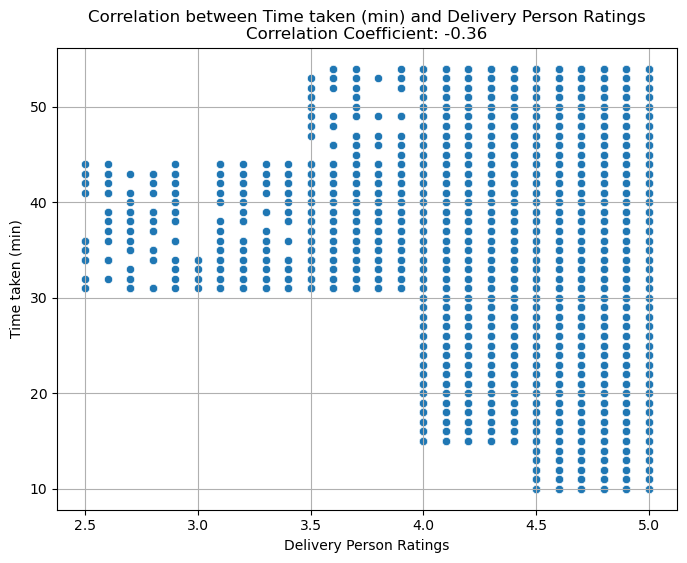

In [8]:
#The variables for the following 5 analyses are not available in the Swiggy data, hence it's only done for the Zomato data to analyze the impact of these factors on the delivery times and performance.
#Calculate the correlation coefficient
correlation = zomato_df['Time_taken (min)'].corr(zomato_df['Delivery_person_Ratings'])

# Plot the correlation chart
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Delivery_person_Ratings', y='Time_taken (min)', data=zomato_df)
plt.title(f'Correlation between Time taken (min) and Delivery Person Ratings\nCorrelation Coefficient: {correlation:.2f}')
plt.xlabel('Delivery Person Ratings')
plt.ylabel('Time taken (min)')
plt.grid(True)
plt.show()

### Hence, we can see that the rating of the delivery partner and the delivery time have no direct correlation i.e., partners with higher ratings, do not necessarily have a lower average delivery time but partners with lower ratings always do have above average delivery times.

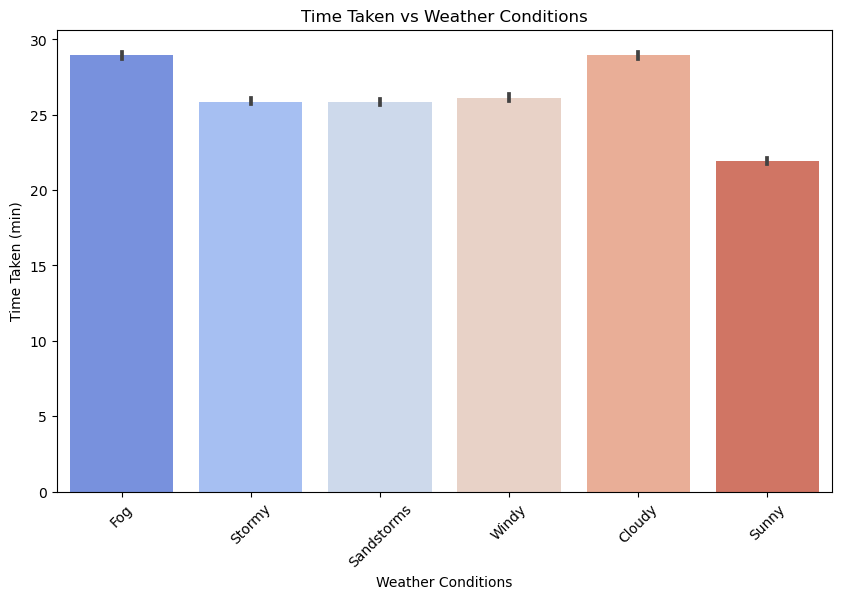

In [9]:
#Plot the time taken to deliver orders in different weather conditions
plt.figure(figsize=(10, 6))
sns.barplot(x='Weather_conditions', y='Time_taken (min)', data=zomato_df, palette='coolwarm')
plt.title('Time Taken vs Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Time Taken (min)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### Hence, we can see that there is a direct correlation between the weather conditions and the delivery time with good conditions like sunny weather having the least average delivery time while foggy and cloudy weathers lead to the highest delivery times.

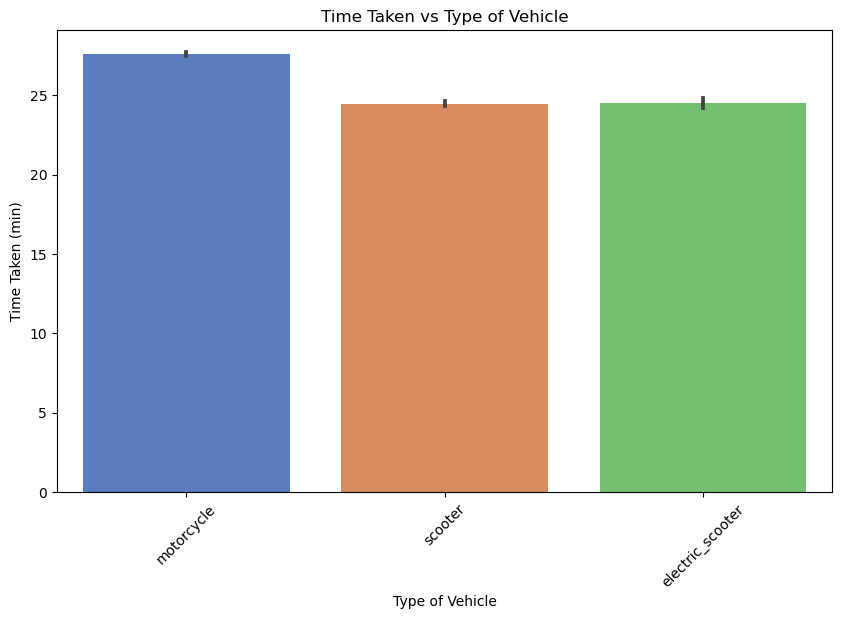

In [10]:
#Plot the time taken to deliver orders against type of vehicle
plt.figure(figsize=(10, 6))
sns.barplot(x='Type_of_vehicle', y='Time_taken (min)', data=zomato_df, palette='muted')
plt.title('Time Taken vs Type of Vehicle')
plt.xlabel('Type of Vehicle')
plt.ylabel('Time Taken (min)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### In summary, motorcycles exhibit the longest delivery times, while scooters and electric scooters display similar, relatively shorter delivery durations. Hence, Zomato could do well to implement more riders with scooters and electric scooters.

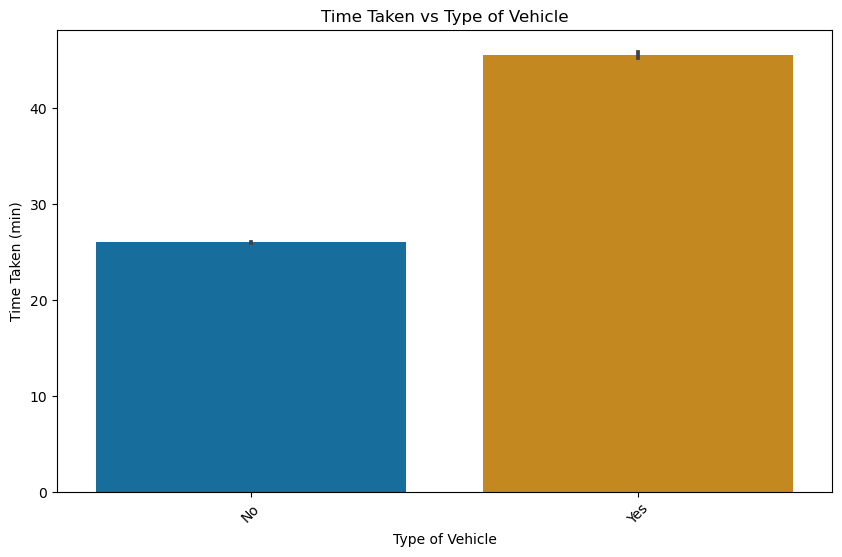

In [11]:
#Plot the time taken to deliver orders against festivals
plt.figure(figsize=(10, 6))
sns.barplot(x='Festival', y='Time_taken (min)', data=zomato_df, palette='colorblind')
plt.title('Time Taken vs Type of Vehicle')
plt.xlabel('Type of Vehicle')
plt.ylabel('Time Taken (min)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### Hence, from the above chart, we can clearly see the average delivery time greatly increases during festivals. Zomato can increase their efficiency by assigning more riders to work during such times.

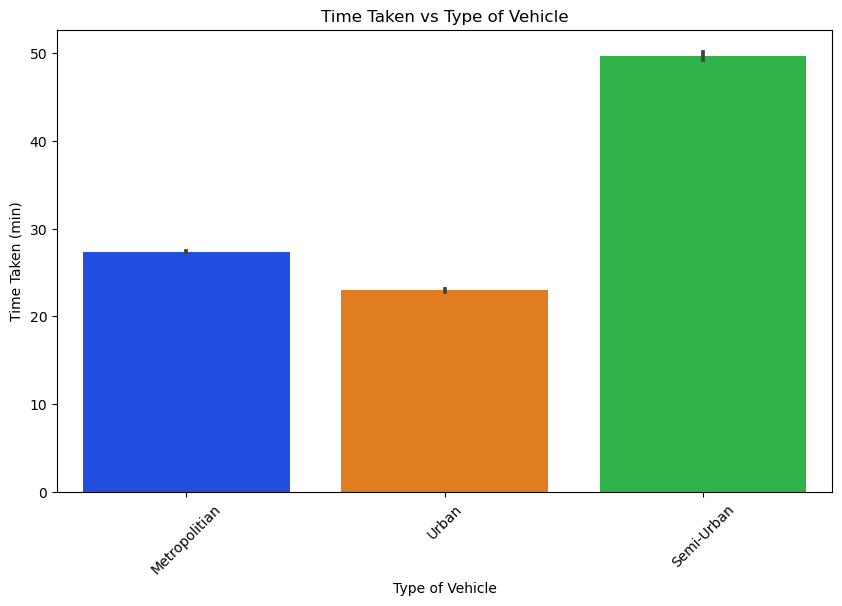

In [12]:
#Plot the time taken to deliver orders against city
plt.figure(figsize=(10, 6))
sns.barplot(x='City', y='Time_taken (min)', data=zomato_df, palette='bright')
plt.title('Time Taken vs Type of Vehicle')
plt.xlabel('Type of Vehicle')
plt.ylabel('Time Taken (min)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### Semi-urban areas experience notably longer delivery times, averaging close to 50 minutes, contrasting with significantly lower durations in metropolitan and urban regions, nearly half of semi-urban times. This discrepancy may stem from factors like less developed infrastructure, longer distances between delivery points, and potentially higher traffic congestion. Solutions could involve optimizing delivery routes, deploying more delivery personnel during peak times, and investing in infrastructure improvements to alleviate congestion and streamline logistics in semi-urban areas.

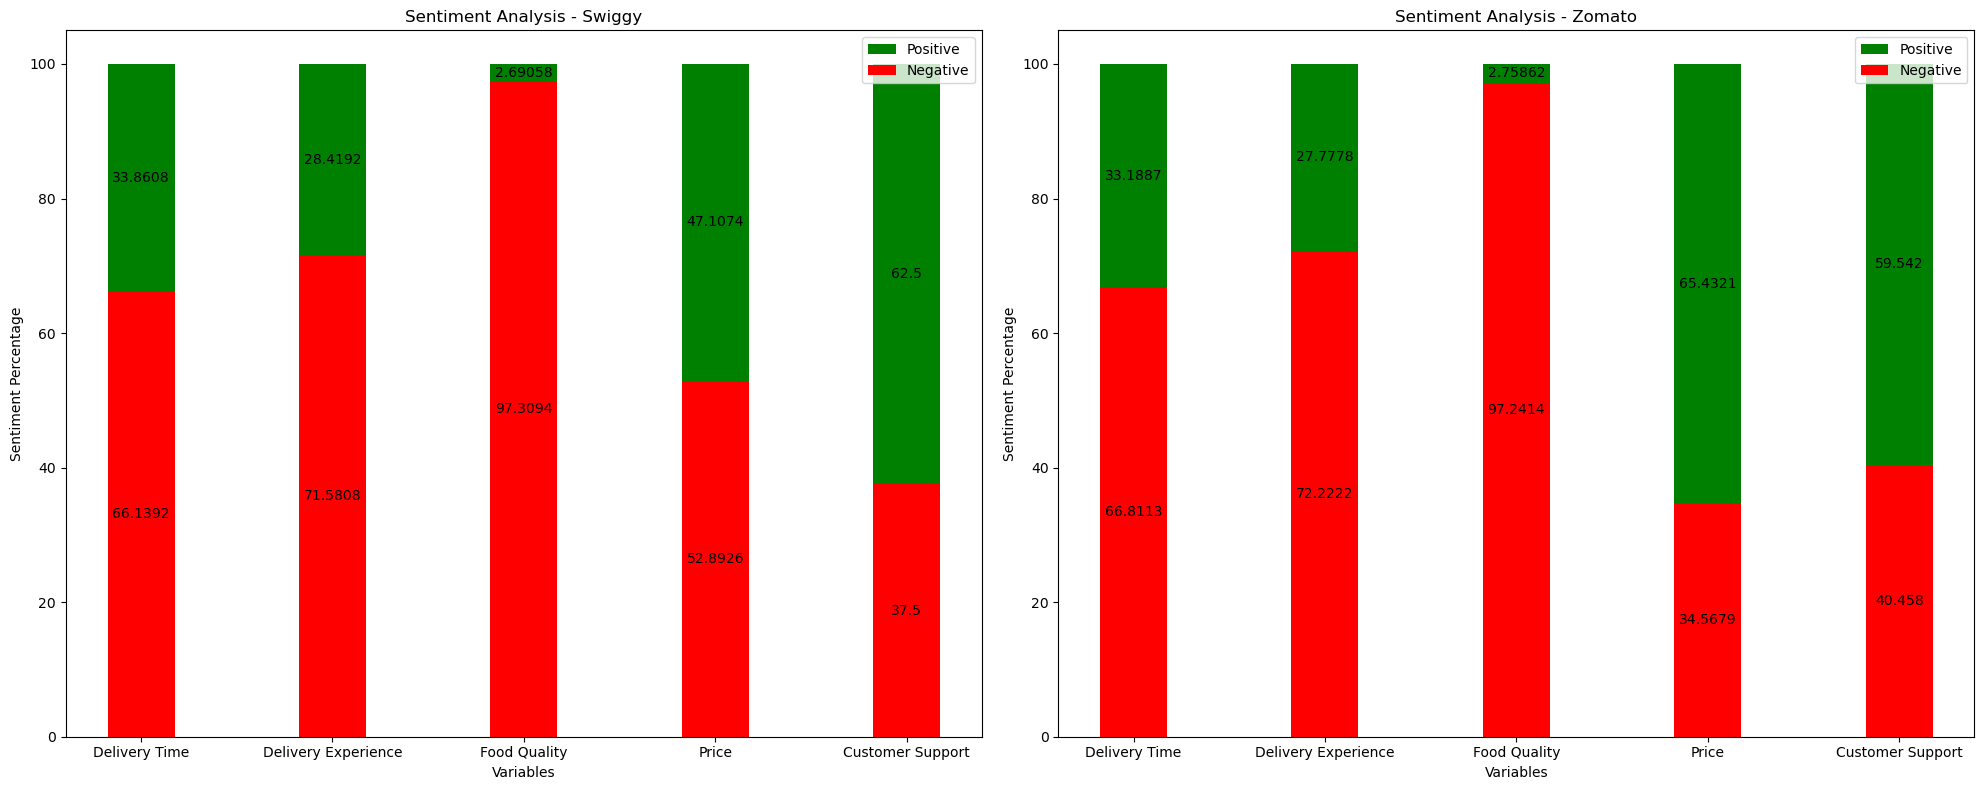

In [13]:
swiggy_data = pd.read_csv(r"C:\Users\shahv\Downloads\Swiggy Tweets.csv")
zomato_data = pd.read_csv(r"C:\Users\shahv\Downloads\Zomato Tweets.csv")

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define criteria or keywords for positive and negative sentiments for each variable
positive_keywords = {
    'delivery_time': ['quick', 'fast', 'speedy', 'efficient', 'prompt', 'timely', 'rapid', 'swift', 'punctual', 'timely',
                      'hasty', 'speedy', 'express', 'on time', 'snappy', 'expeditious', 'promptly', 'in no time', 'immediate', 
                      'swiftly', 'rapidly', 'promptitude', 'timeliness', 'swiftness', 'alacrity', 'promptness', 'instant', 'brisk',
                      'direct', 'promptly', 'straightaway', 'headlong', 'impetuous', 'precipitate', 'promptitude', 'accelerated', 
                      'swift-footed', 'urgent', 'immediate', 'direct', 'timely', 'seasonable', 'opportune', 'prompt', 'early', 
                      'early bird', 'a good time', 'not late', 'well-timed', 'convenient'],
    'delivery_experience': ['excellent', 'amazing', 'great', 'wonderful', 'fantastic', 'awesome', 'stellar', 'superb', 'pleasant', 'satisfactory',
                            'amiable', 'genial', 'good-natured', 'hospitable', 'attentive', 'courteous', 'gracious', 'helpful', 'polite', 
                            'kind-hearted', 'delightful', 'charming', 'enjoyable', 'heart-warming', 'lovable', 'enthusiastic', 'friendly', 
                            'caring', 'compassionate', 'kindly', 'affable', 'agreeable', 'congenial', 'easygoing', 'jovial', 'upbeat', 
                            'positive', 'optimistic', 'cheerful', 'sunny', 'bright', 'joyful', 'merry', 'lively', 'energetic', 'vibrant', 
                            'bubbly', 'dynamic', 'enthusiastic'],
    'food_quality': ['delicious', 'tasty', 'yummy', 'flavorful', 'delectable', 'scrumptious', 'mouthwatering', 'appetizing', 'tempting', 'savoury',
                     'palatable', 'tasteful', 'savory', 'delectable', 'luscious', 'toothsome', 'tasty', 'appetizing', 'delightful', 'mouth-watering', 
                     'scrumptious', 'finger-licking', 'yum-yum', 'sapid', 'pungent', 'saporous', 'delicacy', 'tantalizing', 'delicate', 'delectable', 
                     'flavorful', 'yummy', 'mouth-watering', 'luscious', 'divine', 'delightful', 'scrumptious', 'tasty', 'succulent', 'appetizing', 
                     'flavourful', 'palatable', 'savory', 'delish', 'juicy', 'mouth-watering', 'scrumptious', 'tasteful', 'delightful', 'mouth-watering'],
    'price': ['affordable', 'reasonable', 'budget-friendly', 'value-for-money', 'economical', 'cost-effective', 'fair', 'competitive', 'attractive', 'reasonable',
              'inexpensive', 'moderate', 'low-cost', 'cheap', 'inexpensive', 'bargain', 'economical', 'low-priced', 'reasonably priced', 'cut-rate', 
              'economy', 'bargain-basement', 'low-cost', 'moderate', 'discounted', 'on sale', 'cut-price', 'marked-down', 'sale', 'discount', 'reduced',
              'economical', 'low-priced', 'competitive', 'budget', 'affordable', 'reasonable', 'competitive', 'moderate', 'affordable', 'economical', 
              'low-cost', 'attractive', 'inexpensive', 'reasonably priced', 'moderate', 'budget-friendly', 'low-priced', 'cost-effective', 'fair',
              'reasonably priced', 'moderate'],
    'customer_support': ['helpful', 'friendly', 'responsive', 'efficient', 'courteous', 'attentive', 'supportive', 'prompt', 'professional', 'accommodating',
                         'helping', 'cooperative', 'considerate', 'caring', 'kind', 'sincere', 'considerate', 'thoughtful', 'empathetic', 'sympathetic', 
                         'supportive', 'understanding', 'patient', 'calm', 'polite', 'gentle', 'amiable', 'pleasant', 'friendly', 'welcoming', 'warm', 
                         'inviting', 'cordial', 'affable', 'pleasant', 'helpful', 'friendly', 'responsive', 'efficient', 'courteous', 'attentive', 'supportive', 
                         'prompt', 'professional', 'accommodating', 'helping', 'cooperative', 'considerate', 'caring', 'kind', 'sincere', 'considerate']
}

negative_keywords = {
    'delivery_time': ['slow', 'delayed', 'late', 'unpunctual', 'tardy', 'poor', 'sluggish', 'inconsistent', 'prolonged', 'unreliable',
                      'tardiness', 'slowness', 'leisurely', 'deliberate', 'behind schedule', 'behind time', 'lagging', 'unhurried', 
                      'meandering', 'laggard', 'dilatory', 'idle', 'slow-witted', 'dawdling', 'lagging', 'tardy', 'sluggish', 'snail-like', 
                      'stuck', 'backed-up', 'traffic', 'waiting', 'dead time', 'tarrying', 'retarded', 'behindhand', 'lagged', 
                      'slumbering', 'dozy', 'drowsy', 'torpid', 'lethargic', 'inactive', 'slow-moving', 'languid', 'sedate', 'laid-back', 
                      'slack', 'loose', 'relaxed'],
    'delivery_experience': ['bad', 'poor', 'terrible', 'awful', 'horrible', 'disappointing', 'unsatisfactory', 'unpleasant', 'subpar', 'unacceptable',
                             'nasty', 'awful', 'horrible', 'dire', 'dreadful', 'ghastly', 'lousy', 'unpleasant', 'unsatisfactory', 'inadequate', 
                             'inferior', 'dissatisfying', 'unsatisfying', 'not good', 'not up to par', 'substandard', 'below par', 'displeasing', 
                             'unwelcome', 'unfavorable', 'unpleasing', 'not satisfactory', 'not acceptable', 'deficient', 'wanting', 'faulty', 
                             'flawed', 'incomplete', 'unsound', 'shabby', 'crummy', 'ropy', 'poor-quality', 'second-rate', 'third-rate', 'unpalatable', 
                             'vile', 'disgusting', 'nauseating'],
    'food_quality': ['bad', 'poor', 'awful', 'terrible', 'disgusting', 'nasty', 'inedible', 'inedible', 'tasteless', 'flavorless',
                     'stale', 'rancid', 'spoiled', 'rotten', 'bland', 'soggy', 'dry', 'burnt', 'overcooked', 'undercooked',
                     'salty', 'bitter', 'sour', 'stale', 'mushy', 'greasy', 'oily', 'fatty', 'heavy', 'processed',
                     'artificial', 'stodgy', 'unappetizing', 'unpleasant', 'unpalatable', 'displeasing', 'unsatisfactory',
                     'subpar', 'inferior', 'below par', 'mediocre', 'not good', 'not up to par', 'poor-quality', 'second-rate',
                     'third-rate', 'substandard', 'unsound', 'shabby', 'crummy', 'ropy', 'disappointing'],
    'price': ['expensive', 'overpriced', 'costly', 'pricey', 'high-priced', 'high-cost', 'price tag', 'exorbitant', 'sky-high', 'unaffordable',
              'not worth it', 'rip-off', 'overrated', 'overcharging', 'overvalued', 'inflated', 'extortionate', 'outrageous', 'steep',
              'astronomical', 'luxurious', 'premium', 'splurge', 'lavish', 'over-the-top', 'premium', 'pricy', 'spendy', 'unreasonable',
              'uneconomical', 'pricey', 'too much', 'overbudget', 'expensive', 'costly', 'dear', 'steep', 'big-ticket', 'pricy', 'premium',
              'over-the-top', 'overpriced', 'expensive', 'unreasonable', 'excessive', 'unwarranted', 'overinflated', 'extortionate', 'lavish',
              'high-priced', 'overrated'],
    'customer_support': ['unhelpful', 'unfriendly', 'unresponsive', 'inefficient', 'discourteous', 'inattentive', 'unsupportive', 'slow', 'unprofessional', 'unaccommodating',
                         'unhelping', 'uncooperative', 'inconsiderate', 'uncaring', 'rude', 'insincere', 'inconsiderate', 'thoughtless', 'unempathetic', 'unsympathetic', 
                         'unsupportive', 'unsupportive', 'unconcerned', 'impatient', 'rude', 'abrupt', 'brusque', 'indifferent', 'aloof', 'distant', 'cold', 
                         'unfriendly', 'unwelcoming', 'cold-hearted', 'unapproachable', 'dismissive', 'disinterested', 'apathetic', 'distant', 'unenthusiastic', 
                         'uninterested', 'uncooperative', 'unhelpful', 'unresponsive', 'inefficient', 'discourteous', 'inattentive', 'unsupportive', 'slow', 
                         'unprofessional', 'unaccommodating', 'unhelping', 'uncooperative']
}

# Function to calculate sentiment percentages for a given variable
def calculate_sentiment_percentage(texts, positive_keywords, negative_keywords):
    positive_count = 0
    negative_count = 0
    for text in texts:
        sentiment = sid.polarity_scores(text)
        # Check if any positive keyword present in the text
        if any(keyword in text.lower() for keyword in positive_keywords):
            positive_count += 1
        # Check if any negative keyword present in the text
        if any(keyword in text.lower() for keyword in negative_keywords):
            negative_count += 1
    total_count = positive_count + negative_count
    if total_count == 0:
        return 0, 0
    positive_percentage = (positive_count / total_count) * 100
    negative_percentage = ((negative_count / total_count) * 100)
    return positive_percentage, negative_percentage

# Calculate sentiment percentages for each variable
variables = ['delivery_time', 'delivery_experience', 'food_quality', 'price', 'customer_support']
positive_percentages = {}
negative_percentages = {}
for variable in variables:
    positive_percentages[variable], negative_percentages[variable] = calculate_sentiment_percentage(swiggy_data['clean_text'], positive_keywords[variable], negative_keywords[variable])

# Plot the percentage bar plots for each variable
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
variables = list(positive_percentages.keys())
bar_width = 0.35
index = range(len(variables))

positive_values = list(positive_percentages.values())
negative_values = list(negative_percentages.values())

bar1 = ax1.bar(index, positive_values, bar_width, label='Positive', color='green', bottom=negative_values)
bar2 = ax1.bar(index, negative_values, bar_width, label='Negative', color='red')

ax1.set_xlabel('Variables')
ax1.set_ylabel('Sentiment Percentage')
ax1.set_title('Sentiment Analysis - Swiggy')
ax1.set_xticks(index)
ax1.set_xticklabels(['Delivery Time', 'Delivery Experience', 'Food Quality', 'Price', 'Customer Support'])
ax1.legend()
for c in ax1.containers:
    ax1.bar_label(c, label_type='center')

positive_percentages = {}
negative_percentages = {}
for variable in variables:
    positive_percentages[variable], negative_percentages[variable] = calculate_sentiment_percentage(zomato_data['clean_text'], positive_keywords[variable], negative_keywords[variable])

positive_values = list(positive_percentages.values())
negative_values = list(negative_percentages.values())

bar1 = ax2.bar(index, positive_values, bar_width, label='Positive', color='green', bottom=negative_values)
bar2 = ax2.bar(index, negative_values, bar_width, label='Negative', color='red')

ax2.set_xlabel('Variables')
ax2.set_ylabel('Sentiment Percentage')
ax2.set_title('Sentiment Analysis - Zomato')
ax2.set_xticks(index)
ax2.set_xticklabels(['Delivery Time', 'Delivery Experience', 'Food Quality', 'Price', 'Customer Support'])
ax2.legend()
for c in ax2.containers:
    ax2.bar_label(c, label_type='center')
    
plt.tight_layout()
plt.show()